In [1]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
!pip install adamp

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 91 (delta 0), reused 0 (delta 0), pack-reused 90
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.1 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
     |████████████████████████████████| 448 kB 74.7 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-11-23 10:56:45--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22e9:9f55, 2406:da00:ff00::22c0:3470, ...
Connecti

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adamp import AdamP
#from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import warnings
warnings.filterwarnings('ignore')

import re
import seaborn as sb

# Tools for creating ngrams and vectorizing input data
from konlpy.tag import Mecab
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding, Conv1D, MaxPooling1D, BatchNormalization, Concatenate, Layer, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D, GRU, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
import os
from keras import backend as K
from gensim.models import FastText
from sklearn.neighbors import NearestNeighbors

In [3]:
class Attention(Layer):
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None, bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim  

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [23]:
#Remove morphemes from specific parts-of-speech
def pos_delete(tag, pos):
  for p in pos:
    if (p not in tag) == False:
      if 'VV+' not in tag:
        return False
      else:
        return True
    else:
      continue
  
  return True

#Parts-of-speech list
POS = ['CP', 'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC', 'JO', 'EP', 'EF', 'EC', 'ETN', 'ETM', 'VCP', 'VCN', 'SF', 'SY', 'XSN', 'XSV', 'XSA', 'XR']

#Vectorized using a trained FastText model
def vectorize_data(data, vocab: dict) -> list:
  keys = list(vocab.keys())
  filter_unknown = lambda word: vocab.get(word, None) is not None
  result = []
  for d in data:
    filtered = list(filter(filter_unknown,d))
    res = []
    for f in filtered:
      res.append(vocab[f].index)
    result.append(res)
  
  return result
  
#Make synonym dictionary
def make_synonyms():
  synonyms_number = 5
  word_number = 20000
  embed_mat = ft_model.wv.vectors
  nn = NearestNeighbors(n_neighbors=synonyms_number+1).fit(embed_mat)
  neighbours_mat = nn.kneighbors(embed_mat[1:word_number])[1]
  nei_mat = []

  for i in range(len(neighbours_mat)):
    tmp = [ft_model.wv.index2word[s] for s in neighbours_mat[i]]
    nei_mat.append(tmp)

  synonyms = {nei[0]: nei[1:] for nei in nei_mat}

  return synonyms

#Modify train sentence with synonym dictionary
def modify_sentence(X_pos, synonyms, p=0.5):
    sentence = [ft_model.wv.index2word[x] for x in np.trim_zeros(X_pos)]
    for i in range(len(sentence)):
        if np.random.random() > p:
            try:
                syns = synonyms[sentence[i]]
                sentence[i] = np.random.choice(syns)
            except KeyError:
                pass
    return sentence

#Final function. Generate new hate sentence with synonym dictionary (with modify_sentence function)
def text_generator(X_pad, y_data, synonyms):
  X_pos = X_pad[y_data==1]
  n_texts = 15000
  indexes = np.random.randint(0, X_pos.shape[0], n_texts)
  
  X_gen = np.array([modify_sentence(x, synonyms) for x in X_pos[indexes]])
  y_gen = np.ones(n_texts)

  split_X_gen = []
  for i in range(len(X_gen)):
    split_X_gen.append([gen for gen in X_gen[i]])

  return split_X_gen, y_gen

#Text tokenize function (To use Predictor function)
def text_tokenize(text):
  mecab = Mecab()
  train_tokenized = []

  ps = mecab.pos(text)
  tagged = []
  for p in ps:
    if pos_delete(p[1], POS):
      tagged.append(p[0])
  temp_X = [word for word in tagged]
  train_tokenized.append(temp_X)

  return train_tokenized

#Visulaize confusion matrix
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

#Convert to probability corresponding to each label
def predict_proba(pred):
  proba = []
  for i in range(len(pred)):
    proba.append([float(1-pred[i]), pred[i][0]])
  
  return proba

#Class prediction based on the transformed probability
def class_predict(proba):
  return np.argmax(proba, axis=1)

def model_predict(model, X_test):
  test_pred = model.predict(X_test)
  test_pred_proba = predict_proba(test_pred)
  test_preds = class_predict(test_pred_proba)

  return test_preds

#Determine max_len function
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('Proportion of samples with length %s or less among all samples: %s'%(max_len, (count / len(nested_list))*100))


In [5]:
#Train data load +  Tagging + Spliting + FastText Model load
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/train_data.csv', encoding='cp949')
train_data['comments'] = train_data['comments'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]','')

mecab = Mecab()
train_tokenized = []

for comment in train_data['comments']:
  ps = mecab.pos(comment)
  tagged = []
  for p in ps:
    if pos_delete(p[1], POS):
      tagged.append(p[0])
    temp_X = [word for word in tagged]
  train_tokenized.append(temp_X)

ft_model = FastText.load('/content/drive/MyDrive/Colab Notebooks/model/fasttext_310k_1109.model')

In [6]:
#Make Synonyms dictionary
synonyms = make_synonyms()

In [7]:
#Define X_data and y_data
X_data = train_tokenized
y_data = train_data['hate'].values

In [8]:
#View Ratio Length
below_threshold_len(35, X_data)

Proportion of samples with length 35 or less among all samples: 98.89632936507937


In [9]:
#Comment Vectorize with FastText Model (train_data)
max_len = 35
padded_X = pad_sequences(
    sequences=vectorize_data(X_data, vocab=ft_model.wv.vocab),
    maxlen=max_len,
    padding='post'
)

In [10]:
#Generate Sentence with synonym dictionary
X_pos = padded_X[y_data==1]
split_X_gen, y_gen = text_generator(padded_X, y_data, synonyms)
mix_X = X_data + split_X_gen
mix_y = np.hstack((y_data, y_gen))

#Comment Vectorize with FastText Model (Generate_data)
max_len = 35
X_pad = pad_sequences(
    sequences=vectorize_data(mix_X, vocab=ft_model.wv.vocab),
    maxlen=max_len,
    padding='post'
)

#Final Input data: X_pad(x_data), mix_y(y_data)

In [11]:
#Split train data, validation data and test data
X_train, X_vt, y_train, y_vt = train_test_split(X_pad, mix_y, test_size=0.2, shuffle=True, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_vt, y_vt, test_size=0.3, shuffle=True, random_state=42)

In [12]:
#Define matrics(TP, FP, TN, FN, Accuracy, Precision, Recall, AUC)
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

In [19]:
#Build model
def build_attention(embedding_matrix, maxlen):
  sequence_input = Input(shape=(maxlen,), dtype='int32')
  embedded_sequences = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],  input_length=maxlen, weights=[embedding_matrix], trainable=False)(sequence_input)
  dropout_1 = SpatialDropout1D(0.1)(embedded_sequences)
  bilstm = Bidirectional(LSTM(32, return_sequences=True))(dropout_1)
  bigru = Bidirectional(GRU(32, return_sequences=True))(bilstm)

  atten_1 = Attention(maxlen)(bilstm)
  atten_2 = Attention(maxlen)(bigru)
  avg_pool = GlobalAveragePooling1D()(bigru)
  max_pool = GlobalMaxPooling1D()(bigru)

  conc = concatenate([atten_1, atten_2, avg_pool, max_pool])
  dense = Dense(16, activation='relu')(conc)
  dropout_2 = Dropout(0.1)(dense)
  output = Dense(1, activation='sigmoid')(dropout_2)

  model = Model(inputs=sequence_input, outputs=output)
  #model.summary()

  return model

def build_1dcnn(embedding_matrix, maxlen):
    model = Sequential()
    model.add(Embedding(input_dim = embedding_matrix.shape[0], output_dim = embedding_matrix.shape[1],  input_length = maxlen, weights = [embedding_matrix], trainable=False))
    model.add(Dropout(0.2))
    model.add(Conv1D(50, 5, strides=1, padding='valid', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    #model.summary()

    return model

def build_bilstm(embedding_matrix, maxlen):
    model = Sequential()
    model.add(Embedding(input_dim = embedding_matrix.shape[0], output_dim = embedding_matrix.shape[1],  input_length = maxlen, weights = [embedding_matrix], trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
   # model.summary()

    return model

def build_bilstm_dbl(embedding_matrix, maxlen):
    model = Sequential()
    model.add(Embedding(input_dim = embedding_matrix.shape[0], output_dim = embedding_matrix.shape[1],  input_length = maxlen, weights = [embedding_matrix], trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1, return_sequences=True)))
    model.add(Bidirectional(LSTM(64, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
   # model.summary()

    return model

def build_gru(embedding_matrix, maxlen):
    model = Sequential()
    model.add(Embedding(input_dim = embedding_matrix.shape[0], output_dim = embedding_matrix.shape[1],  input_length = maxlen, weights = [embedding_matrix], trainable=False))
    model.add(GRU(128, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
   # model.summary()

    return model

def build_dbl_1dcnn(embedding_matrix, maxlen):
    model = Sequential()
    model.add(Embedding(input_dim = embedding_matrix.shape[0], output_dim = embedding_matrix.shape[1],  input_length = maxlen, weights = [embedding_matrix], trainable=False))
    model.add(Conv1D(50, 5, strides=1, padding='valid', activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    #model.summary()
    return model

  

In [20]:
#Model define and train, visualize model tree
attention = build_attention(embedding_matrix=ft_model.wv.vectors, maxlen=max_len)
cnn = build_1dcnn(embedding_matrix=ft_model.wv.vectors, maxlen=max_len)
bilstm = build_bilstm(embedding_matrix=ft_model.wv.vectors, maxlen=max_len)
bilstm_dbl = build_bilstm_dbl(embedding_matrix=ft_model.wv.vectors, maxlen=max_len)
gru = build_gru(embedding_matrix=ft_model.wv.vectors, maxlen=max_len)
dbl_1dcnn = build_dbl_1dcnn(embedding_matrix=ft_model.wv.vectors, maxlen=max_len)

attention.compile(loss='binary_crossentropy', optimizer='nadam', metrics=METRICS)
cnn.compile(loss='binary_crossentropy', optimizer='nadam', metrics=METRICS)
bilstm.compile(loss='binary_crossentropy', optimizer='nadam', metrics=METRICS)
bilstm_dbl.compile(loss='binary_crossentropy', optimizer='nadam', metrics=METRICS)
gru.compile(loss='binary_crossentropy', optimizer='nadam', metrics=METRICS)
dbl_1dcnn.compile(loss='binary_crossentropy', optimizer='nadam', metrics=METRICS)

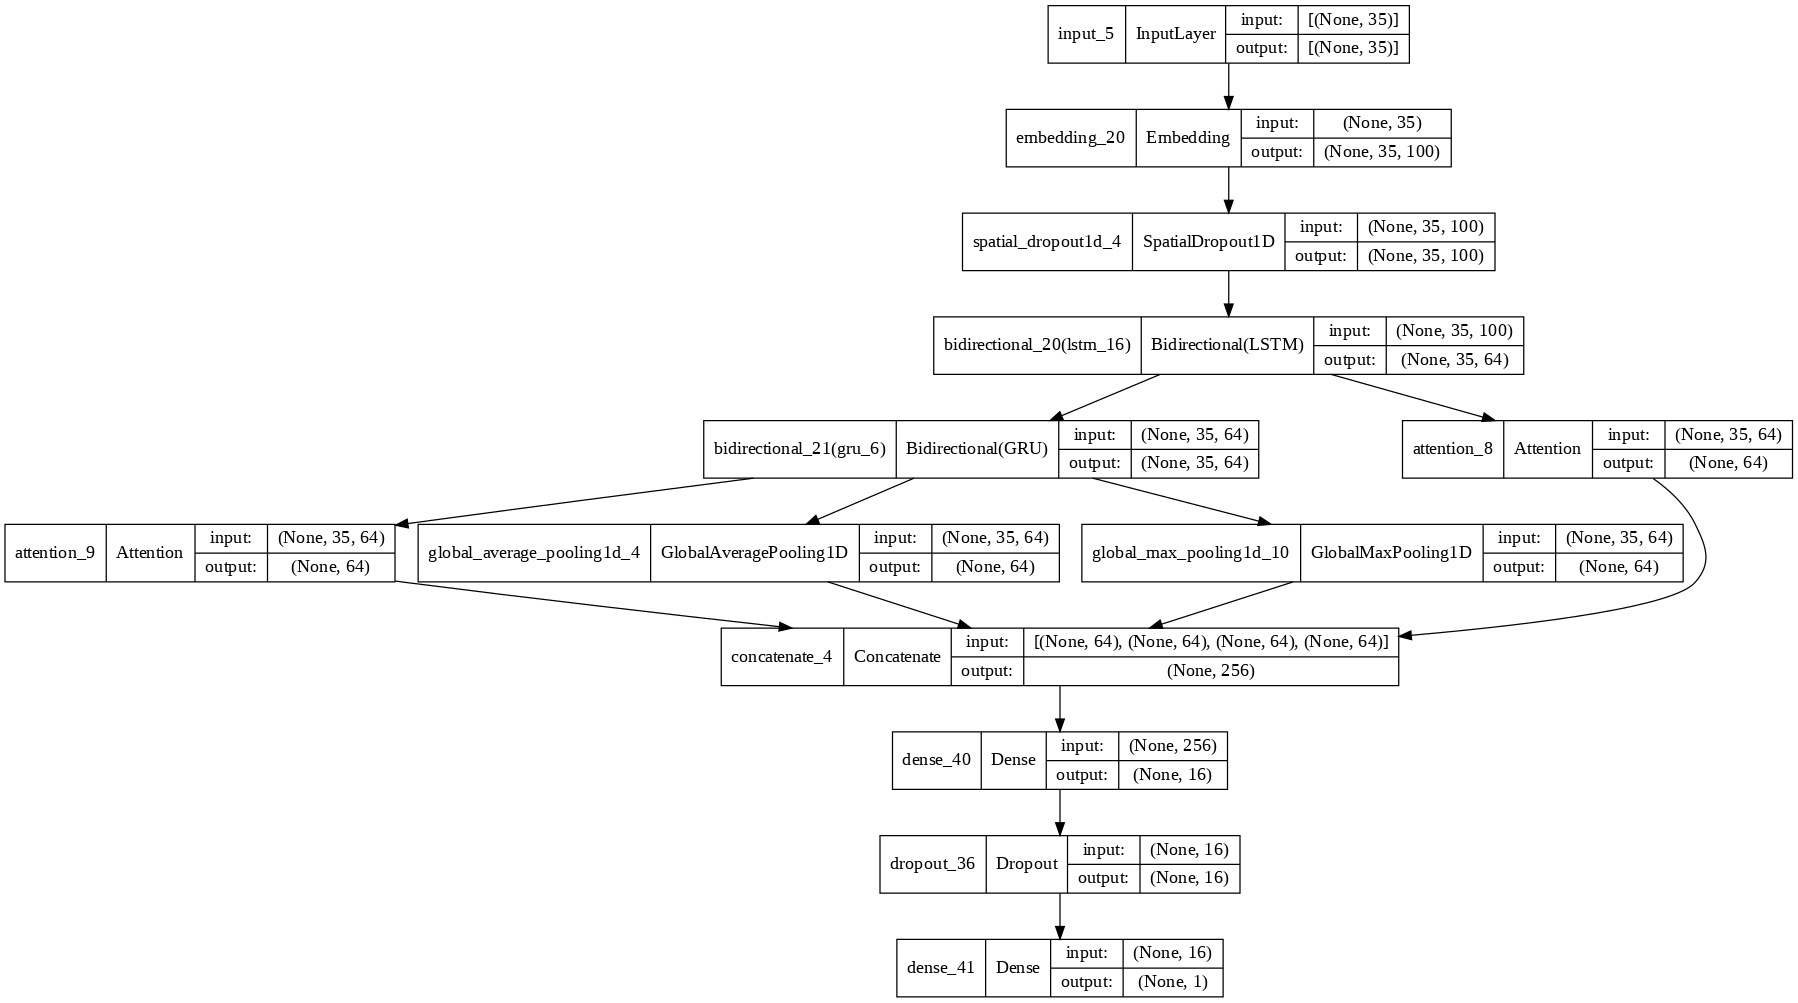

In [26]:
keras.utils.plot_model(attention, show_shapes=True, dpi=90)

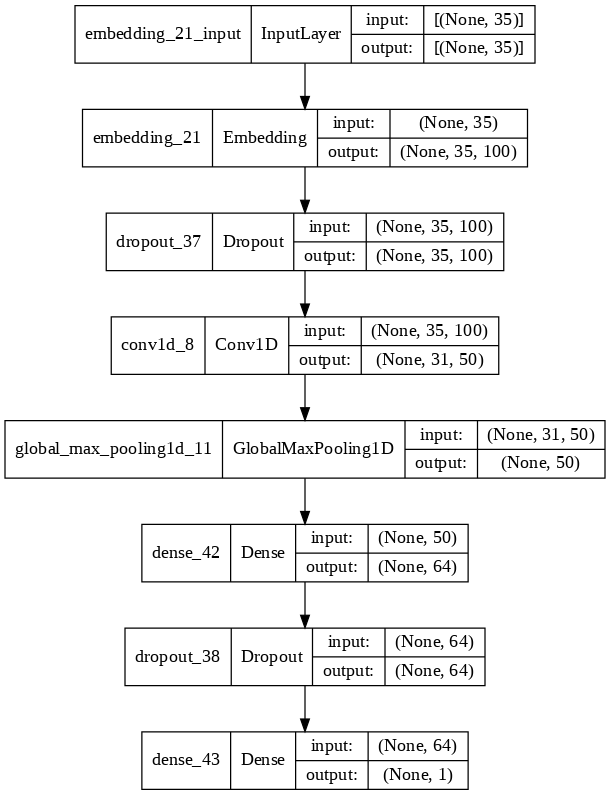

In [27]:
keras.utils.plot_model(cnn, show_shapes=True, dpi=90)

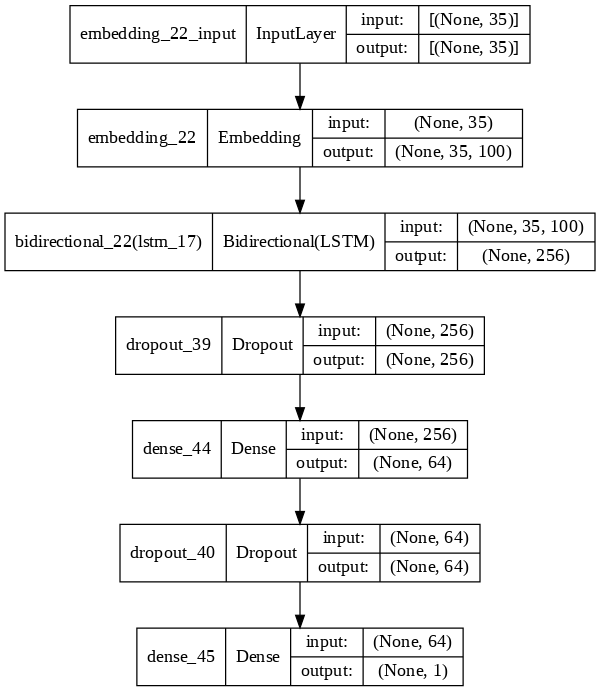

In [28]:
keras.utils.plot_model(bilstm, show_shapes=True, dpi=90)

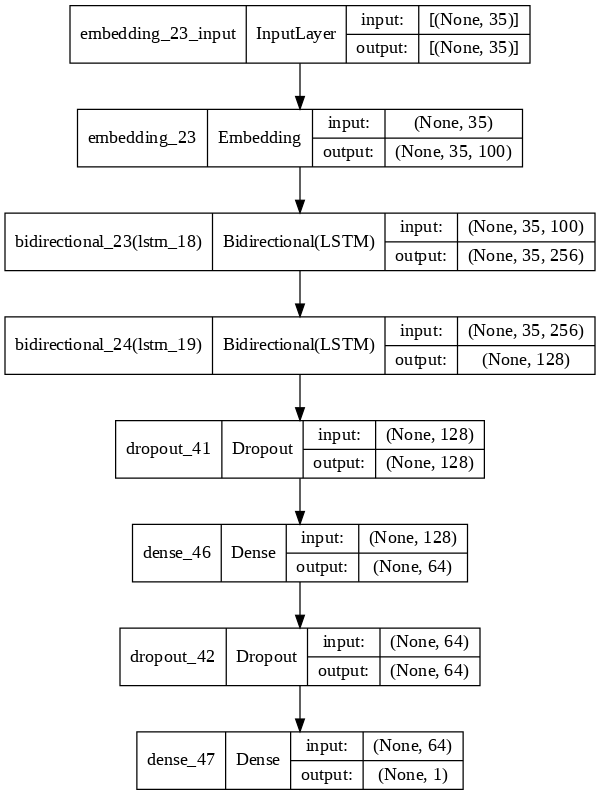

In [29]:
keras.utils.plot_model(bilstm_dbl, show_shapes=True, dpi=90)

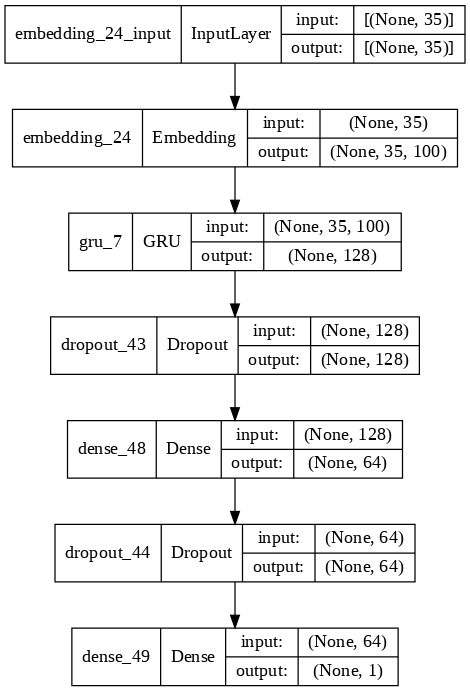

In [30]:
keras.utils.plot_model(gru, show_shapes=True, dpi=90)

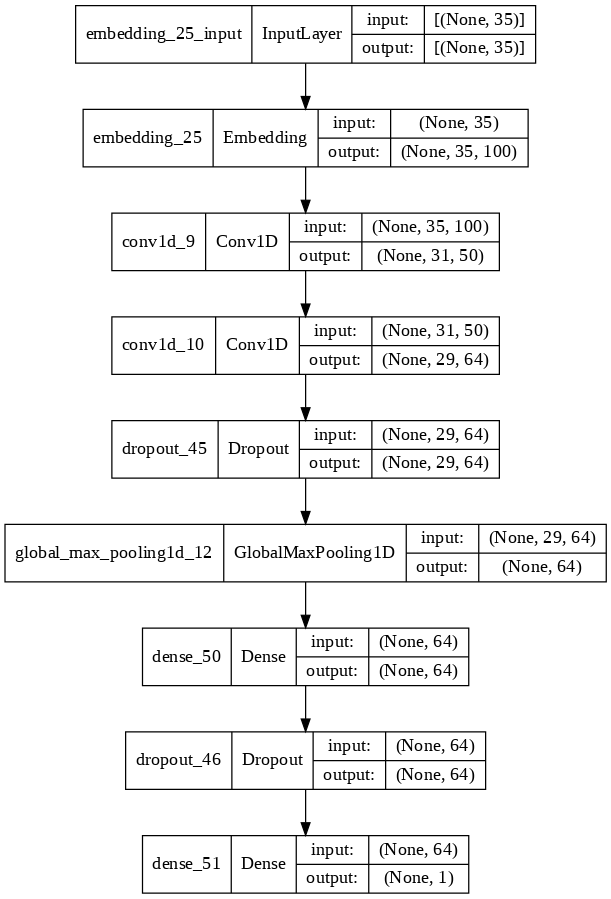

In [32]:
keras.utils.plot_model(dbl_1dcnn, show_shapes=True, dpi=90)

In [ ]:
EPOCHS=15
h_attention = attention.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=100, epochs=EPOCHS)
h_cnn = cnn.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=100, epochs=EPOCHS)
h_bilstm = bilstm.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=100, epochs=EPOCHS)
h_bilstm_dbl = bilstm_dbl.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=100, epochs=EPOCHS)
h_gru = gru.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=100, epochs=EPOCHS)
h_dbl_1dcnn = dbl_1dcnn.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=100, epochs=EPOCHS)

print('Model train complete.')

In [24]:
attention_pred = model_predict(attention, X_test)
cnn_pred = model_predict(cnn, X_test)
bilstm_pred = model_predict(bilstm, X_test)
dbl_bilstm_pred = model_predict(bilstm_dbl, X_test)
gru_pred = model_predict(gru, X_test)
dbl_1dcnn_pred = model_predict(dbl_1dcnn, X_test)

print('Data predict complete.')

Data predict complete.


Attantion Model Classification Report
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.92      1207
         1.0       0.91      0.93      0.92      1145

    accuracy                           0.92      2352
   macro avg       0.92      0.92      0.92      2352
weighted avg       0.92      0.92      0.92      2352

1D-CNN Model Classification Report
              precision    recall  f1-score   support

         0.0       0.95      0.82      0.88      1207
         1.0       0.83      0.96      0.89      1145

    accuracy                           0.89      2352
   macro avg       0.89      0.89      0.89      2352
weighted avg       0.89      0.89      0.89      2352

BiLSTM Model Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      1207
         1.0       0.91      0.91      0.91      1145

    accuracy                           0.91      2352
   macro avg       0

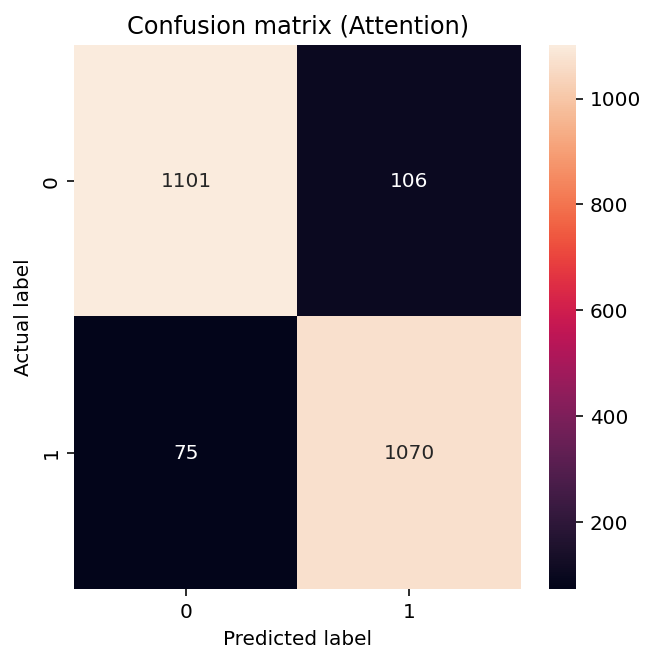

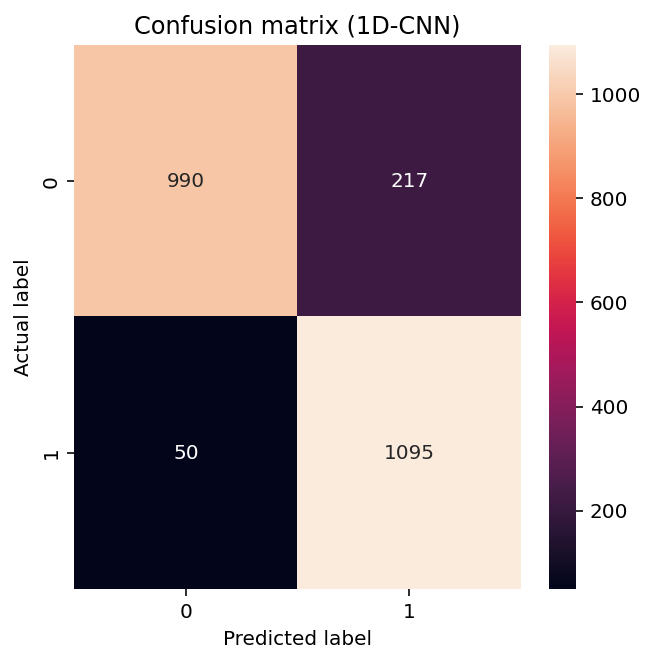

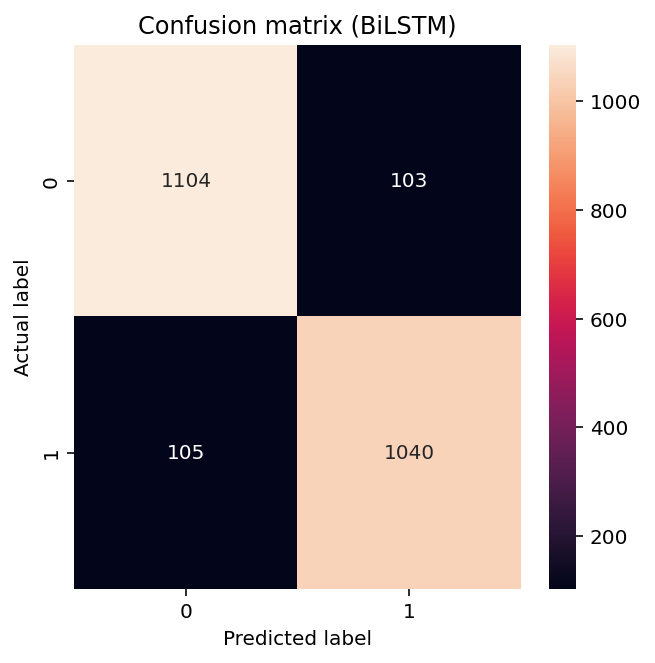

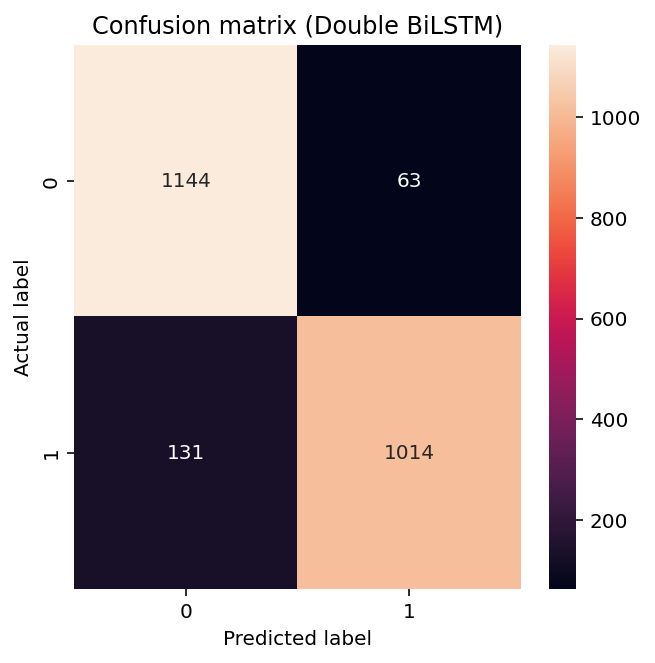

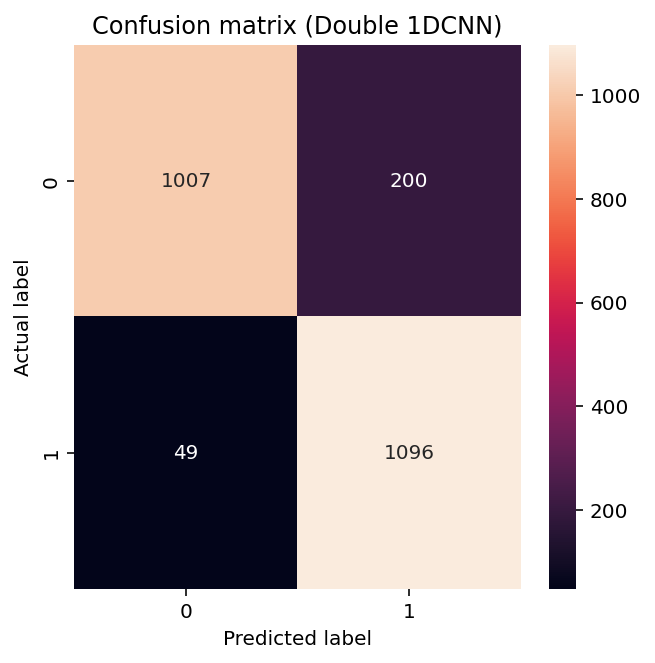

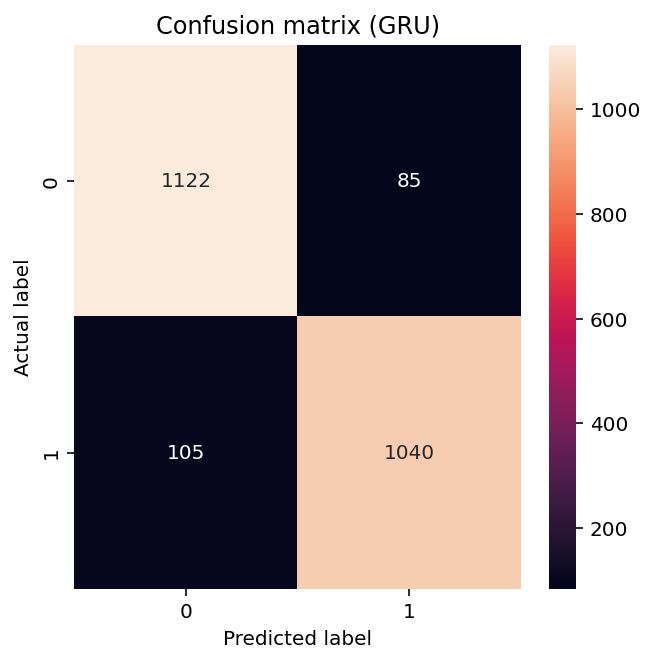

In [25]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

report_att = classification_report(y_test, attention_pred)
report_cnn = classification_report(y_test, cnn_pred)
report_bi = classification_report(y_test, bilstm_pred)
report_bidb = classification_report(y_test, dbl_bilstm_pred)
report_dbl1d = classification_report(y_test, dbl_1dcnn_pred)
report_gru = classification_report(y_test, gru_pred)

print('Attantion Model Classification Report')
print(report_att)
print('1D-CNN Model Classification Report')
print(report_cnn)
print('BiLSTM Model Classification Report')
print(report_bi)
print('Double-BiLSTM Model Classification Report')
print(report_bidb)
print('Double-1DCNN Model Classification Report')
print(report_dbl1d)
print('GRU Model Classification Report')
print(report_gru)

def plot_cm(labels, predictions, name, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (" + name + ')')
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    
plot_cm(y_test, attention_pred, 'Attention')
plot_cm(y_test, cnn_pred, '1D-CNN')
plot_cm(y_test, bilstm_pred, 'BiLSTM')
plot_cm(y_test, dbl_bilstm_pred, 'Double BiLSTM')
plot_cm(y_test, dbl_1dcnn_pred, 'Double 1DCNN')
plot_cm(y_test, gru_pred, 'GRU')

In [33]:
def predictor(text, model, vocab=ft_model.wv.vocab, maxlen=max_len):
  pattern = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣]')
  text = re.sub(pattern, ' ', text)
  tokenized = text_tokenize(text)
  tokenized_padded = pad_sequences(sequences=vectorize_data(tokenized, vocab=vocab), maxlen=maxlen, padding='post')

  print("Regexed Text:         ", text)
  print("Tokenized Text:       ", tokenized)
  ratio = round(model.predict(tokenized_padded)[0][0] * 100, 2)
  print(f'{ratio}% 확률로 욕설 문장입니다.')
  print('----------------------------------------')
  print('욕설 부분 분석\n')
  badword_list = []
  for idx, token in enumerate(tokenized[0]):
    pad_token = pad_sequences(sequences=vectorize_data([[token]], vocab=ft_model.wv.vocab), maxlen=35, padding='post')
    token_ratio = round(model.predict(pad_token)[0][0] * 100, 2)
    print(token + '\t: ' + str(token_ratio) +'% 확률로 욕설 부분')
    if token_ratio > 50:
      badword_list.append(token)
  
  return badword_list

In [34]:
def masker(text, badword):
  masked_text = text
  for bad in badword:
    masked_text = masked_text.replace(bad, '*' * len(bad), 1)
  
  return masked_text

In [35]:
def pred_mask(model, text):
  badword = predictor(text, model)
  masked_text = masker(text, badword)
  print('\n')
  print('Original Text: ', text)
  print('Masked Text: ', masked_text)
  print('-' * 80)

In [36]:
text='이 프로그램이 우리 계획의 시발점이다. '

print('1DCNN MODEL')
pred_mask(cnn, text)

print('BILSTM MODEL')
pred_mask(bilstm, text)

print('DOUBLE BILSTM MODEL')
pred_mask(bilstm_dbl, text)

print('ATTENTION MODEL')
pred_mask(attention, text)

print('DOUBLE 1DCNN MODEL')
pred_mask(dbl_1dcnn, text)

print('GRU MODEL')
pred_mask(gru, text)

1DCNN MODEL
Regexed Text:          이 프로그램이 우리 계획의 시발점이다  
Tokenized Text:        [['이', '프로그램', '우리', '계획', '시발점']]
15.64% 확률로 욕설 문장입니다.
----------------------------------------
욕설 부분 분석

이	: 30.23% 확률로 욕설 부분
프로그램	: 2.63% 확률로 욕설 부분
우리	: 9.93% 확률로 욕설 부분
계획	: 40.11% 확률로 욕설 부분
시발점	: 48.46% 확률로 욕설 부분


Original Text:  이 프로그램이 우리 계획의 시발점이다. 
Masked Text:  이 프로그램이 우리 계획의 시발점이다. 
--------------------------------------------------------------------------------
BILSTM MODEL
Regexed Text:          이 프로그램이 우리 계획의 시발점이다  
Tokenized Text:        [['이', '프로그램', '우리', '계획', '시발점']]
0.07% 확률로 욕설 문장입니다.
----------------------------------------
욕설 부분 분석

이	: 30.02% 확률로 욕설 부분
프로그램	: 2.37% 확률로 욕설 부분
우리	: 3.54% 확률로 욕설 부분
계획	: 2.94% 확률로 욕설 부분
시발점	: 24.44% 확률로 욕설 부분


Original Text:  이 프로그램이 우리 계획의 시발점이다. 
Masked Text:  이 프로그램이 우리 계획의 시발점이다. 
--------------------------------------------------------------------------------
DOUBLE BILSTM MODEL
Regexed Text:          이 프로그램이 우리 계획의 시발점이다  
Tokenized Text:      

In [37]:
text='아 씨발 진짜 개 좆같네'

print('1DCNN MODEL')
pred_mask(cnn, text)

print('BILSTM MODEL')
pred_mask(bilstm, text)

print('DOUBLE BILSTM MODEL')
pred_mask(bilstm_dbl, text)

print('ATTENTION MODEL')
pred_mask(attention, text)

print('DOUBLE 1DCNN MODEL')
pred_mask(dbl_1dcnn, text)

print('GRU MODEL')
pred_mask(gru, text)

1DCNN MODEL
Regexed Text:          아 씨발 진짜 개 좆같네
Tokenized Text:        [['아', '씨발', '진짜', '개', '좆같']]
99.95% 확률로 욕설 문장입니다.
----------------------------------------
욕설 부분 분석

아	: 32.88% 확률로 욕설 부분
씨발	: 98.95% 확률로 욕설 부분
진짜	: 44.72% 확률로 욕설 부분
개	: 78.85% 확률로 욕설 부분
좆같	: 68.72% 확률로 욕설 부분


Original Text:  아 씨발 진짜 개 좆같네
Masked Text:  아 ** 진짜 * **네
--------------------------------------------------------------------------------
BILSTM MODEL
Regexed Text:          아 씨발 진짜 개 좆같네
Tokenized Text:        [['아', '씨발', '진짜', '개', '좆같']]
99.54% 확률로 욕설 문장입니다.
----------------------------------------
욕설 부분 분석

아	: 5.85% 확률로 욕설 부분
씨발	: 99.66% 확률로 욕설 부분
진짜	: 6.4% 확률로 욕설 부분
개	: 85.1% 확률로 욕설 부분
좆같	: 77.99% 확률로 욕설 부분


Original Text:  아 씨발 진짜 개 좆같네
Masked Text:  아 ** 진짜 * **네
--------------------------------------------------------------------------------
DOUBLE BILSTM MODEL
Regexed Text:          아 씨발 진짜 개 좆같네
Tokenized Text:        [['아', '씨발', '진짜', '개', '좆같']]
99.98% 확률로 욕설 문장입니다.
-----------------------